## To be or Not to Be


This Project intends to use Exploratory data analysis, some of feature engineering techniques in order to  build classification models for determining the players in Shakespeare Plays Using other columns as features

<br>Main focus would be on Feature engineering and Classification Models

Steps undertaken:<br>
Data Preprocessing, Exploratory data analysis <br>
Feature Extraction, Feature Transformation, Feature Selection Using PCA <br>
Classification Models : Decision Trees, Naive Bayes, Logistic Regression



## Loading Dataset and Importing Required modules


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import string
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import io

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
df = pd.read_csv('./Shakespeare_data.csv') 

In [3]:
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


Some knowledge about data

Data-Line just keeps track of rows, hence not required<br>
Play - The play that the respective lines(PlayerLine) are form<br>
PlayerLinunumber: Actual Line being spoke at any given time<br>
ActSceneLine: Act-Scene-Line from which any given line is from.<br>
Player: Player saying the line<br>
PlayerLine: Line being spoken<br>

## Data Preprocessing, EDA, Feature Engineering

In [4]:
df.shape

(111396, 6)

In [5]:
df.isnull().sum()

Dataline               0
Play                   0
PlayerLinenumber       3
ActSceneLine        6243
Player                 7
PlayerLine             0
dtype: int64

After seeing the data, we can drop the Dataline as it simply counts the rows as Index

As Observed in the dataset, there are some missing values, while it's a general tendency to drop the entire rows, there is one more technique called "Imputation" and we will make use of it.

We will Impute the 'null' or 'na' values in the column using maximum occured value 

In [6]:
df['ActSceneLine'].fillna(df['ActSceneLine'].value_counts() .idxmax(), inplace=True)
df['PlayerLinenumber'].fillna(df['PlayerLinenumber'].value_counts().idxmax(), inplace=True)
df['Player'].fillna(df['Player'].value_counts().idxmax(), inplace=True)

In [7]:
df.drop('Dataline',axis=1,inplace=True)
df.head()

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,Henry IV,1.0,5.1.3,GLOUCESTER,ACT I
1,Henry IV,1.0,5.1.3,GLOUCESTER,SCENE I. London. The palace.
2,Henry IV,1.0,5.1.3,GLOUCESTER,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [8]:
#shows number of unique players to classify
df.Player.nunique()

934

In [9]:
df.Play.nunique()

36

In [10]:
df.PlayerLine.nunique()

107580

In [11]:
df.drop_duplicates(subset=['PlayerLine'],keep='first',inplace=True)

In [12]:
#columns with object data-type could be used for categorical encoding
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107580 entries, 0 to 111394
Data columns (total 5 columns):
Play                107580 non-null object
PlayerLinenumber    107580 non-null float64
ActSceneLine        107580 non-null object
Player              107580 non-null object
PlayerLine          107580 non-null object
dtypes: float64(1), object(4)
memory usage: 4.9+ MB


## EDA


In [13]:
df.dtypes

Play                 object
PlayerLinenumber    float64
ActSceneLine         object
Player               object
PlayerLine           object
dtype: object

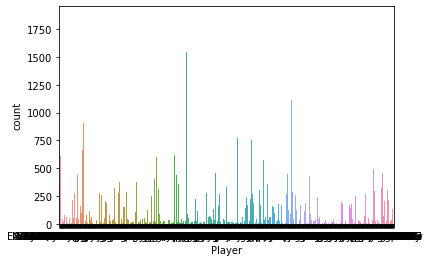

In [14]:
sns.countplot(df['Player'],label="Count")
plt.show()

Play Count

In [15]:
df['Play'].value_counts()

Hamlet                      4099
Coriolanus                  3892
Cymbeline                   3855
Richard III                 3777
Antony and Cleopatra        3737
King Lear                   3610
Othello                     3591
Troilus and Cressida        3568
A Winters Tale              3393
Henry VIII                  3342
Henry V                     3306
Henry VI Part 2             3273
Romeo and Juliet            3175
Henry IV                    3161
Henry VI Part 3             3069
Alls well that ends well    2996
Measure for measure         2889
Richard II                  2876
Henry VI Part 1             2862
Loves Labours Lost          2803
As you like it              2736
Merchant of Venice          2727
Taming of the Shrew         2720
King John                   2718
Merry Wives of Windsor      2704
Titus Andronicus            2669
Julius Caesar               2668
Much Ado about nothing      2630
Timon of Athens             2551
Pericles                    2544
Twelfth Ni

### Feature Extraction

ActSceneLine has three different values and these can be split into individual columns to give more meaning to data

In [16]:
actsceneline=df['ActSceneLine'].str.split('.',n=-1,expand=True)
df1=df
df1['Act']=actsceneline[0]
df1['Scene']=actsceneline[1]
df1['Line']=actsceneline[2]

In [17]:
df1.head()

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,Line
0,Henry IV,1.0,5.1.3,GLOUCESTER,ACT I,5,1,3
1,Henry IV,1.0,5.1.3,GLOUCESTER,SCENE I. London. The palace.,5,1,3
2,Henry IV,1.0,5.1.3,GLOUCESTER,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ...",5,1,3
3,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",1,1,1
4,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",1,1,2


Box plot for each numerical or categorical variable will give us a clearer idea of the distribution of the input variables

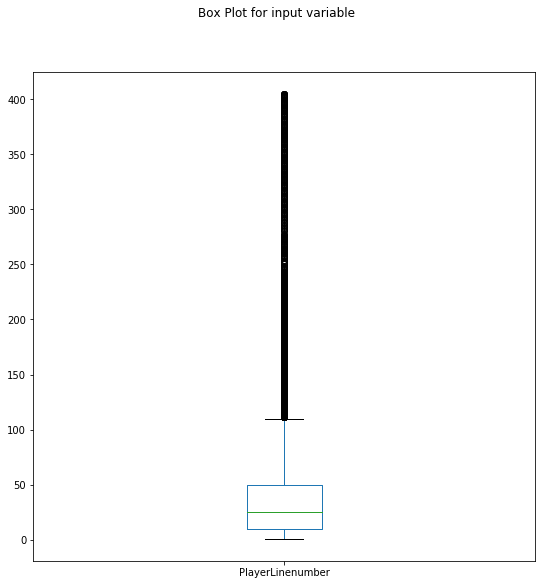

In [18]:
df1.drop('Player', axis=1).plot(kind='box', subplots=True, layout=(1,1) ,figsize=(9,9),  title='Box Plot for input variable')
plt.show()

Boxplot can also be used to analyze relationship between categorical  variable and continous variable

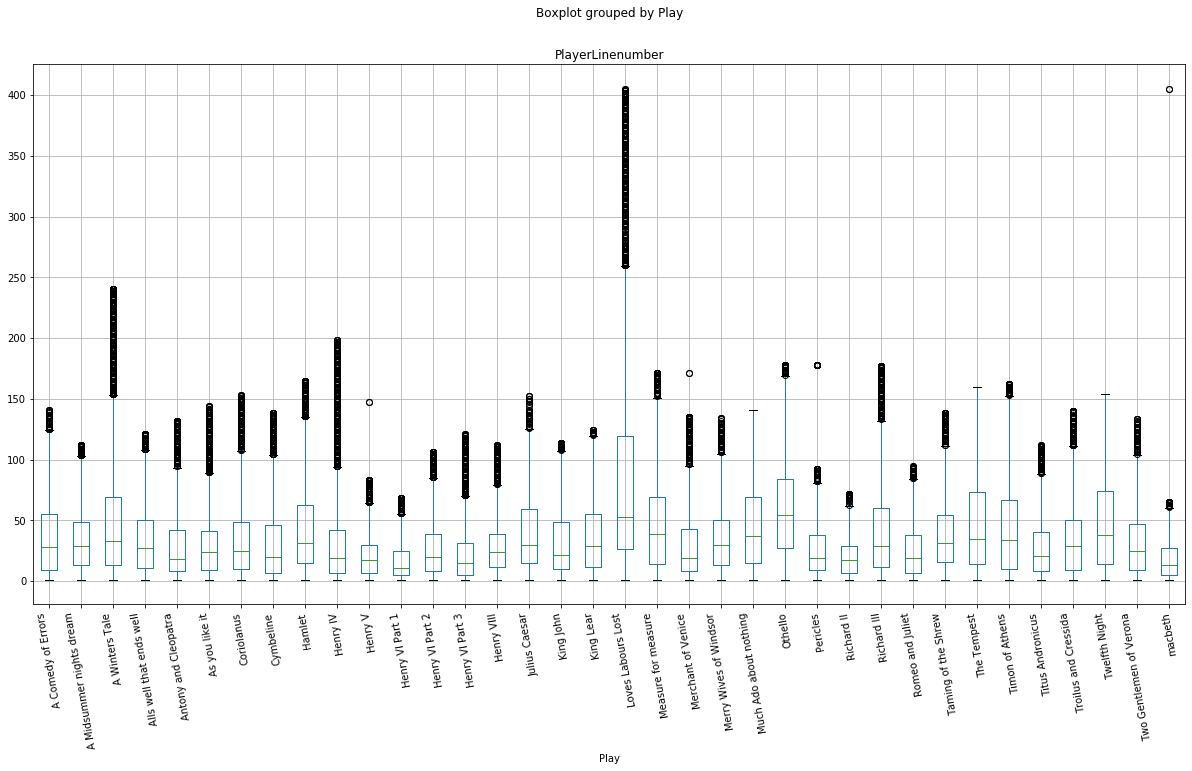

In [19]:
df1.boxplot('PlayerLinenumber','Play',rot=100,figsize=(20,10))

## Feature Transformation

In datasets like this where we have multiple data types, it becomes challenging to apply transforms to some, but not all inputs

We will make use of <b>Scikit ColumnTransformer </b> that allows you to selectively apply data transforms to different columns in your dataset.

In [20]:
df1.head()

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,Line
0,Henry IV,1.0,5.1.3,GLOUCESTER,ACT I,5,1,3
1,Henry IV,1.0,5.1.3,GLOUCESTER,SCENE I. London. The palace.,5,1,3
2,Henry IV,1.0,5.1.3,GLOUCESTER,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ...",5,1,3
3,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",1,1,1
4,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",1,1,2


Since we have 36 unique <b>Plays</b> and this is a categorical variable, it's better to apply <b>onehot encoding</b>. For numerical columns like 
act,scene and line, we will proceed with <b>StandardScalar</b> and PlayerLine will be exploited later

In [21]:
df.dtypes

Play                 object
PlayerLinenumber    float64
ActSceneLine         object
Player               object
PlayerLine           object
Act                  object
Scene                object
Line                 object
dtype: object

In [22]:
df1.drop('ActSceneLine',axis=1,inplace=True)

In [48]:
df1.head()

,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
0,Henry IV,1.0,GLOUCESTER,ACT I,5,1,3
1,Henry IV,1.0,GLOUCESTER,SCENE I. London. The palace.,5,1,3
2,Henry IV,1.0,GLOUCESTER,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ...",5,1,3
3,Henry IV,1.0,KING HENRY IV,"So shaken as we are, so wan with care,",1,1,1
4,Henry IV,1.0,KING HENRY IV,"Find we a time for frighted peace to pant,",1,1,2


In [35]:
X,Y= df1.drop(columns=['PlayerLine','Player','Act','Scene','Line']),df['Player']

In [36]:
numerical_col=X.select_dtypes(include=['int64','float64']).columns
categorical_col=X.select_dtypes(include=['object']).columns

In [38]:
categorical_col

Index(['Play'], dtype='object')

In [40]:
numerical_col

Index(['PlayerLinenumber'], dtype='object')

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [42]:
trans = [('cat', OneHotEncoder(), categorical_col), ('num', MinMaxScaler(), numerical_col)]
col_transform = ColumnTransformer(transformers=trans)

In [43]:
print(trans)

[('cat', OneHotEncoder(), Index(['Play'], dtype='object')), ('num', MinMaxScaler(), Index(['PlayerLinenumber'], dtype='object'))]


In [44]:
trans

[('cat', OneHotEncoder(), Index(['Play'], dtype='object')),
 ('num', MinMaxScaler(), Index(['PlayerLinenumber'], dtype='object'))]

In [45]:
X.head()

,Play,PlayerLinenumber
0,Henry IV,1.0
1,Henry IV,1.0
2,Henry IV,1.0
3,Henry IV,1.0
4,Henry IV,1.0


In [46]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(
    X,Y, random_state=0)

In [47]:
X_train=col_transform.fit_transform(X_train)

In [48]:
X_train

<80685x37 sparse matrix of type '<class 'numpy.float64'>'
	with 157612 stored elements in Compressed Sparse Row format>

In [49]:
X_test = col_transform.transform(X_test)

## Classification

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
classifier= DecisionTreeClassifier(criterion='entropy')

In [52]:
classifier.fit(X_train,Y_train)

DecisionTreeClassifier(criterion='entropy')

In [55]:
player_pred =  classifier.predict(X_test)

In [57]:
from sklearn.metrics import accuracy_score
print('Accuracy Score on train data: ', accuracy_score(y_true=Y_train, y_pred=classifier.predict(X_train)))
print('Accuracy Score on test data: ', accuracy_score(y_true=Y_test, y_pred=player_pred))

Accuracy Score on train data:  0.46314680547809384
Accuracy Score on test data:  0.41089421825618144


### Using PlayerLine as a feature for vectorizing the text and applying classification model on it

In [86]:
#using df1 as dataframe
label=df1['Player']
d=df1['PlayerLine']

In [97]:
from sklearn.preprocessing import LabelEncoder
pl = LabelEncoder()
player_labels = pl.fit_transform(df1['Player'])
player_mappings = {index: label for index, label in 
                  enumerate(pl.classes_)}
player_mappings

{0: 'A Lord',
 1: 'A Patrician',
 2: 'A Player',
 3: 'AARON',
 4: 'ABERGAVENNY',
 5: 'ABHORSON',
 6: 'ABRAHAM',
 7: 'ACHILLES',
 8: 'ADAM',
 9: 'ADRIAN',
 10: 'ADRIANA',
 11: 'ADRIANO DE ARMADO',
 12: 'AEGEON',
 13: 'AEMELIA',
 14: 'AEMILIUS',
 15: 'AENEAS',
 16: 'AEdile',
 17: 'AGAMEMNON',
 18: 'AGRIPPA',
 19: 'AJAX',
 20: 'ALBANY',
 21: 'ALCIBIADES',
 22: 'ALENCON',
 23: 'ALEXANDER',
 24: 'ALEXAS',
 25: 'ALICE',
 26: 'ALL',
 27: 'ALONSO',
 28: 'AMIENS',
 29: 'ANDROMACHE',
 30: 'ANGELO',
 31: 'ANGUS',
 32: 'ANNE',
 33: 'ANNE PAGE',
 34: 'ANOTHER',
 35: 'ANTIGONUS',
 36: 'ANTIOCHUS',
 37: 'ANTIPHOLUS',
 38: 'ANTONIO',
 39: 'ANTONY',
 40: 'APEMANTUS',
 41: 'ARCHBISHOP OF YORK',
 42: 'ARCHIDAMUS',
 43: 'ARIEL',
 44: 'ARMADO',
 45: 'ARRAGON',
 46: 'ARTEMIDORUS',
 47: 'ARTHUR',
 48: 'ARVIRAGUS',
 49: 'ATTENDANT',
 50: 'AUDREY',
 51: 'AUFIDIUS',
 52: 'AUSTRIA',
 53: 'AUTOLYCUS',
 54: 'Abbot',
 55: 'All',
 56: 'All Citizens',
 57: 'All Conspirators',
 58: 'All Ladies',
 59: 'All Lords',
 60:

In [98]:
label=player_labels

In [87]:
tfidf=TfidfVectorizer(sublinear_tf=True,min_df=10,ngram_range=(1,2),stop_words='english')
features=tfidf.fit_transform(d)
features.shape

(107580, 5834)

In [99]:
player_labels.shape

(107580,)

In [100]:
features.shape

(107580, 5834)

In [101]:
features.dtype

dtype('float64')

In [102]:
d_train,d_test,label_train,label_test=train_test_split(d,player_labels,random_state=0)

In [107]:
count_vect = CountVectorizer()
d_train_count = count_vect.fit_transform(d_train)
tfidf_transformer = TfidfTransformer()
d_train_tfidf = tfidf_transformer.fit_transform(d_train_count)

In [ ]:
from sklearn.linear_model import LogisticRegression
classified_LogReg = LogisticRegression().fit(d_train_tfidf, label_train)
CLR_Score=classified_LogReg.score(count_vect.transform(d_test), label_test)
CNB_ScoreCNB_Score